In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [85]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

In [183]:
year = '17'
model = 'model_old'

In [184]:
data = pd.read_csv(f'../outputs/{year}/out{year}.csv', index_col='Unnamed: 0')
triggers = pd.read_csv(f'../outputs/{year}/triggers{year}.csv', index_col='label')
reg_eff = pd.read_csv(f'../outputs/{model}/out{model}.csv', index_col='Unnamed: 0')

In [185]:
data

,Nsig,dNsig,index,lum_err,lum,dEmin,dEmax,Emean
641.0,305.56,18.96,1,3.34,3097.96,0.00,0.00,641.02
650.0,93.45,10.37,2,1.81,876.63,0.00,0.00,649.77
675.0,81.40,9.80,3,2.22,1225.14,0.00,0.00,674.85
700.0,36.81,6.88,4,1.94,876.66,0.00,0.00,700.56
725.0,59.88,8.88,5,2.27,1114.22,0.00,0.00,724.94
750.0,92.37,10.78,6,2.34,1107.58,0.00,0.00,749.55
800.0,162.93,13.54,7,2.63,1241.54,0.00,0.00,800.86
825.0,187.49,14.67,8,2.87,1381.86,0.00,0.00,825.05
840.0,77.51,9.65,9,1.98,635.65,0.00,0.00,839.47
860.0,29.74,5.97,10,2.44,922.38,0.00,0.00,857.23


Triggers

In [186]:
triggers.tail()

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
label,,,,,,,,,
870.0,9.0,1.0,19.0,0.91,0.67,0.97,0.06,0.08,0.02
900.0,21.0,3.0,24.0,0.86,0.53,0.94,0.06,0.07,0.03
935.0,19.0,7.0,45.0,0.85,0.70,0.96,0.05,0.06,0.02
960.0,7.0,2.0,26.0,0.90,0.77,0.98,0.05,0.07,0.01
990.0,14.0,0.0,40.0,0.98,0.73,0.99,0.02,0.06,0.01


In [187]:
reg_eff.head()

,Nsig,dNsig,index,lum_err,lum,dEmin,dEmax,Emean
550.0,1590.29,41.28,1,84.63,7163,0.0,0.0,550.0
562.5,1353.86,38.47,2,79.41,6306,0.0,0.0,562.5
575.0,1196.61,36.00,3,74.27,5516,0.0,0.0,575.0
587.5,1103.46,34.54,4,71.53,5116,0.0,0.0,587.5
600.0,960.04,32.57,5,67.87,4606,0.0,0.0,600.0


Get N/L

In [188]:
data['CSvis'] = data['Nsig']/data['lum']
data['dCSvis'] = data['dNsig']/data['lum']

Trigger join

In [189]:
data = data.join(triggers[['TrigEff', 'TrigErr']], how='left')

In [190]:
data = data.drop(['Nsig', 'dNsig', 'lum', 'index', 'lum_err'], axis=1)

Get Reg_eff

In [191]:
reg_eff['RegEff'] = reg_eff['Nsig']/reg_eff['lum']
reg_eff['RegErr'] = reg_eff['dNsig']/reg_eff['lum']
reg_eff.drop(['dEmax', 'dEmin', 'lum', 'Nsig', 'dNsig'], axis=1, inplace=True)

Reg eff join

In [192]:
data['RegEff'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegEff), axis=1)
data['RegErr'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegErr), axis=1)

Recalc cross section

In [193]:
data['CS'] = data['CSvis']/data['TrigEff']/data['RegEff'];
data['dCS'] = data['CS']*np.sqrt( np.square( data['dCSvis']/data['CSvis'] ) + 
                                np.square( data['TrigErr']/data['TrigEff'] ) + 
                                np.square( data['RegErr']/data['RegEff'] ))

In [194]:
data.drop(['CSvis', 'dCSvis', 'TrigEff', 'TrigErr', 'RegEff', 'RegErr'], axis=1, inplace=True)

In [195]:
data.to_csv(f'../outputs/{year}/result_new.csv')

## Draw cross sections

In [196]:
cs11 = pd.read_csv('../outputs/11/result_new.csv', index_col=['Unnamed: 0'])
cs12 = pd.read_csv('../outputs/12/result_new.csv', index_col=['Unnamed: 0'])
cs17 = pd.read_csv('../outputs/17/result_new.csv', index_col=['Unnamed: 0'])
cs19 = pd.read_csv('../outputs/19/result_new.csv', index_col=['Unnamed: 0'])

In [197]:
#radcor = pd.read_csv('rad_cors.dat', delimiter='\t', names=['energy', 'radcor'], index_col=['energy'])
radcor = pd.read_csv('../outputs/radcors.dat', names=['energy', 'radcor'], index_col=['energy'])
radcor.index *= 0.5e3
radcor = radcor.sort_index()

In [198]:
cs11.tail()

,dEmin,dEmax,Emean,CS,dCS
850.0,0.00,0.00,846.43,0.372718,0.087461
862.5,0.00,0.00,861.56,0.348254,0.104785
880.0,8.15,7.89,878.97,0.129951,0.042370
910.0,14.83,13.04,911.28,0.152648,0.044970
950.0,28.82,37.90,964.41,0.042082,0.020519


In [199]:
radcor.head()

,radcor
energy,
550.0,0.771796
562.5,0.779035
575.0,0.785582
587.5,0.790523
600.0,0.796150


In [200]:
cs11['rad'] = np.interp(cs11.Emean, radcor.index, radcor.radcor)
cs12['rad'] = np.interp(cs12.Emean, radcor.index, radcor.radcor)
cs17['rad'] = np.interp(cs17.Emean, radcor.index, radcor.radcor)
cs19['rad'] = np.interp(cs19.Emean, radcor.index, radcor.radcor)

In [201]:
def born(data):
    data['born'] = data.CS/data.rad
    data['born_err'] = data.dCS/data.rad

In [202]:
born(cs11)
born(cs12)
born(cs17)
born(cs19)

In [203]:
errE = dict()
errE[11] = [cs11.dEmin*2e-3, cs11.dEmax*2e-3]
errE[12] = [cs12.dEmin*2e-3, cs12.dEmax*2e-3]
errE[17] = [cs17.dEmin*2e-3, cs17.dEmax*2e-3]
errE[19] = [cs19.dEmin*2e-3, cs19.dEmax*2e-3]

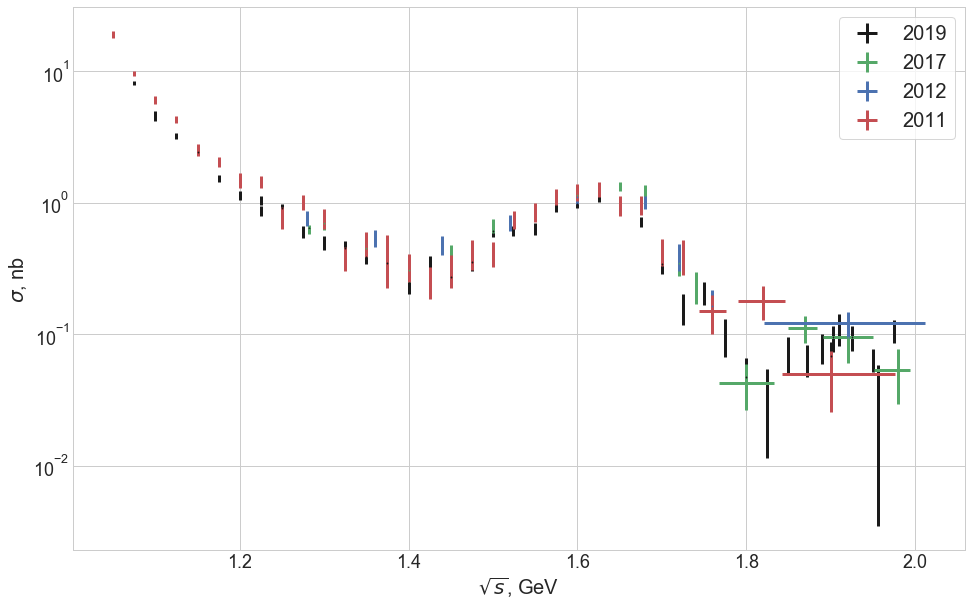

In [208]:
plt.errorbar(cs19.index*2e-3, cs19.born, yerr=cs19.born_err, xerr=errE[19], fmt='kd', elinewidth=3, ms=1, label='2019')
plt.errorbar(cs17.index*2e-3, cs17.born, yerr=cs17.born_err, xerr=errE[17], fmt='g^', elinewidth=3, ms=1, label='2017')
plt.errorbar(cs12.index*2e-3, cs12.born, yerr=cs12.born_err, xerr=errE[12], fmt='bp', elinewidth=3, ms=1, label='2012')
plt.errorbar(cs11.index*2e-3, cs11.born, yerr=cs11.born_err, xerr=errE[11], fmt='rv', elinewidth=3, ms=1, label='2011')
plt.yscale('log')
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma$, nb', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=18)
ax.legend(fontsize=20, frameon=True)
#plt.savefig('cs.pdf')